In [3]:
# !pip install captum
# !pip install torchsummary


import os
import numpy as np
import pandas as pd
import glob
from PIL import Image
import matplotlib.pyplot as plt

from skimage import io, transform
from torchvision import transforms, utils
import torch
import torchvision
from torch import optim
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor
from torchsummary import summary

from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
from functools import partial

from sklearn.metrics import confusion_matrix
import seaborn as sn

from matplotlib.colors import LinearSegmentedColormap
from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

#### Define Dataset

In [7]:
class CellNucleiDataset(Dataset):
    """Cell Nuclei dataset."""

    def __init__(self, csv_file, root_dir, transform=None, target_transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.train_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.train_frame)

    def __getitem__(self, idx):

        img_name = os.path.join(self.root_dir, self.train_frame.iloc[idx, 0])
        image = io.imread(img_name)
        label = self.train_frame.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)
            
        if self.target_transform:
            label = self.target_transform(label)

        return image, label

#### Iterate through the dataset, print the size, label and sample itself of the first 4 samples

0 torch.Size([3, 100, 100]) 0
1 torch.Size([3, 100, 100]) 0
2 torch.Size([3, 100, 100]) 0
3 torch.Size([3, 100, 100]) 0


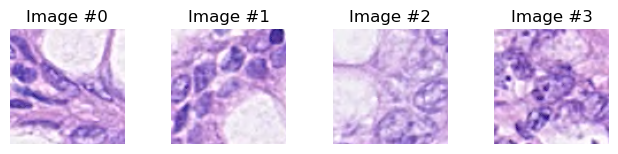

In [4]:
train_dataset = CellNucleiDataset(csv_file='/kaggle/input/deep-learning-for-msc-2022-23/train.csv',
                                  root_dir='/kaggle/input/deep-learning-for-msc-2022-23/train/',
                                  transform = ToTensor())

fig = plt.figure()

for i in range(len(train_dataset)):
    image = train_dataset[i][0]
    label = train_dataset[i][1]

    print(i, image.shape, label)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Image #{}'.format(i))
    ax.axis('off')
    plt.imshow(np.transpose(image.numpy(), (1, 2, 0)))

    if i == 3:
        plt.show()
        break

#### Load dataset into a Dataloader, and print the samples in the first batch

0 torch.Size([4, 3, 100, 100]) torch.Size([4])
1 torch.Size([4, 3, 100, 100]) torch.Size([4])
2 torch.Size([4, 3, 100, 100]) torch.Size([4])
3 torch.Size([4, 3, 100, 100]) torch.Size([4])


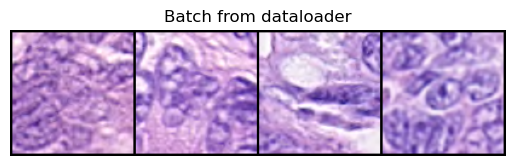

In [5]:
dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched[0].size(), sample_batched[1].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        images_batch = sample_batched[0]
        batch_size = len(images_batch)
        im_size = images_batch.size(2)
        grid_border_size = 2

        grid = utils.make_grid(images_batch)
        plt.imshow(grid.numpy().transpose((1, 2, 0)))
        plt.title('Batch from dataloader')
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

#### Define a Convolution Neural Network with most 8 layers
I suppose it is without input and output layer, a 7-layer CNN network is defined below.  
It has four convolution layers and three fully-connected layers with batch normalization between each layer and dropout layer in FC layers to make our model better and prevent overfitting.   
And also set the layer size of fc layer in our model configurable for hyperparameter tuning.


In [6]:
class ConvNet(nn.Module):
    def __init__(self, l1 = 512, l2 = 64):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)        # 3 input channels, 16 output channels, 3x3 kernal, padding 1
        self.bn1 = nn.BatchNorm2d(16)                      # batch normalization of 16 channels
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)       # 16 input channels, 32 output channels, 3x3 kernal, padding 1
        self.bn2 = nn.BatchNorm2d(32)                      # batch normalization of 32 channels
        self.pool1 = nn.MaxPool2d(2, 2)                    # max pooling 2x2 kernal, stride 2

        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)       # 32 input channels, 64 output channels, 3x3 kernal, padding 1
        self.bn3 = nn.BatchNorm2d(64)                      # batch normalization of 64 channels
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)      # 64 input channels, 128 output channels, 3x3 kernal, padding 1
        self.bn4 = nn.BatchNorm2d(128)                     # batch normalization of 128 channels
        self.pool2 = nn.MaxPool2d(2, 2)                    # max pooling 2x2 kernal, stride 2

        self.fc1 = nn.Linear(128 * 25 * 25, l1)            # input size: 128 * 25 * 25, output size: l1 
        self.bn5 = nn.BatchNorm1d(l1)                      # batch normalization of l1
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(l1, l2)                       # input size: l1, output size: l2 
        self.bn6 = nn.BatchNorm1d(l2)                      # batch normalization of l2
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(l2, 4)                        # input size: l2, output size: 4

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)

        x = x.view(-1, 128 * 25 * 25)
        x = F.relu(self.bn5(self.fc1(x)))
        x = self.dropout1(x)
        x = F.relu(self.bn6(self.fc2(x)))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

#### Define a training session just for Ray tune
Configs = The size of FC layer 1, the size of FC layer 2,  learning rate, and batch size

In [9]:
def train_Conv(config, epoch_num = 10, checkpoint_dir=None, data_dir=None):
    net = ConvNet(config["l1"], config["l2"])
    

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            net = nn.DataParallel(net)
    net.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=config["lr"])

    if checkpoint_dir:
        model_state, optimizer_state = torch.load(
            os.path.join(checkpoint_dir, "checkpoint"))
        net.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)

    trainset = CellNucleiDataset(csv_file='/kaggle/input/deep-learning-for-msc-2022-23/train.csv',
                                 root_dir='/kaggle/input/deep-learning-for-msc-2022-23/train/',
                                 transform = ToTensor())

    test_abs = int(len(trainset) * 0.8)
    train_subset, val_subset = random_split(
        trainset, [test_abs, len(trainset) - test_abs])

    trainloader = DataLoader(
        train_subset,
        batch_size=int(config["batch_size"]),
        shuffle=True,
        num_workers=8)
    valloader = DataLoader(
        val_subset,
        batch_size=int(config["batch_size"]),
        shuffle=True,
        num_workers=8)

    for epoch in range(epoch_num):  # loop over the dataset multiple times
        running_loss = 0.0
        epoch_steps = 0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            epoch_steps += 1
            if i % 2000 == 1999:  # print every 2000 mini-batches
                print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1,
                                                running_loss / epoch_steps))
                running_loss = 0.0

        # Validation loss
        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        for i, data in enumerate(valloader, 0):
            with torch.no_grad():
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = net(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                loss = criterion(outputs, labels)
                val_loss += loss.cpu().numpy()
                val_steps += 1

        with tune.checkpoint_dir(epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, "checkpoint")
            torch.save((net.state_dict(), optimizer.state_dict()), path)

        tune.report(loss=(val_loss / val_steps), accuracy=correct / total)
    print("Finished Training")

#### Define main function for ray tune
Because of the hardware limitation, run for only three samples with a maximum of 10 epochs and use one GPU T4 for each trial.  
Configs set as below:  
* layer size of fc layer 1: 2^5 ~ 2^11  
* layer size of fc layer 2: 2^4 ~ 2^6  
* learning rate: 10e-4 ~ 10e-1  
* batch size: 2, 4, 8 , 16

In [10]:
def main(num_samples=10, max_num_epochs=10, gpus_per_trial=1):
    config = {
        "l1": tune.sample_from(lambda _: 2 ** np.random.randint(5, 11)),
        "l2": tune.sample_from(lambda _: 2 ** np.random.randint(4, 6)),
        "lr": tune.loguniform(1e-4, 1e-1),
        "batch_size": tune.choice([2, 4, 8, 16])
    }
    scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=max_num_epochs,
        grace_period=1,
        reduction_factor=2)
    reporter = CLIReporter(
        parameter_columns=["l1", "l2", "lr", "batch_size"],
        metric_columns=["loss", "accuracy", "training_iteration"])
    result = tune.run(
        partial(train_Conv, data_dir='/kaggle/input/deep-learning-for-msc-2022-23/train'),
        resources_per_trial={"cpu": 2, "gpu": gpus_per_trial},
        config=config,
        num_samples=num_samples,
        scheduler=scheduler,
        progress_reporter=reporter)

    best_trial = result.get_best_trial("loss", "min", "last")
    print("Best trial config: {}".format(best_trial.config))
    print("Best trial final validation loss: {}".format(best_trial.last_result["loss"]))
    print("Best trial final validation accuracy: {}".format(best_trial.last_result["accuracy"]))

    best_trained_model = ConvNet(best_trial.config["l1"], best_trial.config["l2"])
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if gpus_per_trial > 1:
            best_trained_model = nn.DataParallel(best_trained_model)
    best_trained_model.to(device)

    best_checkpoint_dir = best_trial.checkpoint.dir_or_data
    model_state, optimizer_state = torch.load(os.path.join(best_checkpoint_dir, "checkpoint"))
    best_trained_model.load_state_dict(model_state)
    
if __name__ == "__main__":
    # You can change the number of GPUs per trial here:
    main(num_samples=3, max_num_epochs=10, gpus_per_trial=1)

2023-03-27 08:06:03,289	INFO worker.py:1535 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
/opt/conda/lib/python3.7/site-packages/ray/tune/trainable/function_trainable.py:612: DeprecationWarning: `checkpoint_dir` in `func(config, checkpoint_dir)` is being deprecated. To save and load checkpoint in trainable functions, please use the `ray.air.session` API:

from ray.air import session

def train(config):
    # ...
    session.report({"metric": metric}, checkpoint=checkpoint)

For more information please see https://docs.ray.io/en/master/tune/api_docs/trainable.html

  DeprecationWarning,
E0327 08:06:06.034239107    1096 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-27 08:06:06 (running for 00:00:00.37)
Memory usage on this node: 1.9/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 2.0/2 CPUs, 1.0/2 GPUs, 0.0/6.95 GiB heap, 0.0/3.48 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_Conv_2023-03-27_08-06-06
Number of trials: 3/3 (2 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+------+------+-------------+--------------+
| Trial name             | status   | loc             |   l1 |   l2 |          lr |   batch_size |
|------------------------+----------+-----------------+------+------+-------------+--------------|
| train_Conv_3976f_00000 | RUNNING  | 172.19.2.2:1405 |   32 |   32 | 0.000931656 |            4 |
| train_Conv_3976f_00001 | PENDING  |                 |  256 |   16 | 0.0625883   |            2 |
| train_Conv_3976f_00002 | PENDING  |           

(func pid=1405) /opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=1405)   cpuset_checked))


== Status ==
Current time: 2023-03-27 08:06:17 (running for 00:00:11.34)
Memory usage on this node: 3.4/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 2.0/2 CPUs, 1.0/2 GPUs, 0.0/6.95 GiB heap, 0.0/3.48 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_Conv_2023-03-27_08-06-06
Number of trials: 3/3 (2 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+------+------+-------------+--------------+
| Trial name             | status   | loc             |   l1 |   l2 |          lr |   batch_size |
|------------------------+----------+-----------------+------+------+-------------+--------------|
| train_Conv_3976f_00000 | RUNNING  | 172.19.2.2:1405 |   32 |   32 | 0.000931656 |            4 |
| train_Conv_3976f_00001 | PENDING  |                 |  256 |   16 | 0.0625883   |            2 |
| train_Conv_3976f_00002 | PENDING  |           

Trial name,accuracy,date,done,episodes_total,experiment_id,hostname,iterations_since_restore,loss,node_ip,pid,should_checkpoint,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
train_Conv_3976f_00000,0.73545,2023-03-27_08-11-32,True,,11bcccccb66949458e8e9b53902bae94,de2a3adefe2a,10,0.71973,172.19.2.2,1405,True,320.477,28.9686,320.477,1679904692,0,,10,3976f_00000,0.0088141
train_Conv_3976f_00001,0.373016,2023-03-27_08-12-48,True,,5861891c5e0e4acc8c877d0ec34897aa,de2a3adefe2a,1,1.17112,172.19.2.2,3534,True,69.7596,69.7596,69.7596,1679904768,0,,1,3976f_00001,0.00486803
train_Conv_3976f_00002,0.833995,2023-03-27_08-16-59,True,,d19a0780d493474b8a4d6d7da80b32cb,de2a3adefe2a,10,0.486269,172.19.2.2,3815,True,244.756,25.7529,244.756,1679905019,0,,10,3976f_00002,0.00714087


(func pid=1405) E0327 08:06:55.524699971    1443 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-27 08:07:00 (running for 00:00:54.15)
Memory usage on this node: 4.8/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: -0.8510238971344377
Resources requested: 2.0/2 CPUs, 1.0/2 GPUs, 0.0/6.95 GiB heap, 0.0/3.48 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_Conv_2023-03-27_08-06-06
Number of trials: 3/3 (2 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+------+------+-------------+--------------+----------+------------+----------------------+
| Trial name             | status   | loc             |   l1 |   l2 |          lr |   batch_size |     loss |   accuracy |   training_iteration |
|------------------------+----------+-----------------+------+------+-------------+--------------+----------+------------+----------------------|
| train_Conv_3976f_00000 | RUNNING  | 172.19.2.2:1405 |   32 |   32 | 0.000931656 |       

(func pid=1405) E0327 08:07:23.334245456    1443 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-27 08:07:25 (running for 00:01:19.21)
Memory usage on this node: 4.8/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: -0.8510238971344377
Resources requested: 2.0/2 CPUs, 1.0/2 GPUs, 0.0/6.95 GiB heap, 0.0/3.48 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_Conv_2023-03-27_08-06-06
Number of trials: 3/3 (2 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+------+------+-------------+--------------+----------+------------+----------------------+
| Trial name             | status   | loc             |   l1 |   l2 |          lr |   batch_size |     loss |   accuracy |   training_iteration |
|------------------------+----------+-----------------+------+------+-------------+--------------+----------+------------+----------------------|
| train_Conv_3976f_00000 | RUNNING  | 172.19.2.2:1405 |   32 |   32 | 0.000931656 |       

(func pid=1405) E0327 08:07:28.577758968    1443 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-27 08:07:33 (running for 00:01:27.30)
Memory usage on this node: 4.8/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: -0.8351980573522351 | Iter 1.000: -0.8510238971344377
Resources requested: 2.0/2 CPUs, 1.0/2 GPUs, 0.0/6.95 GiB heap, 0.0/3.48 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_Conv_2023-03-27_08-06-06
Number of trials: 3/3 (2 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+------+------+-------------+--------------+----------+------------+----------------------+
| Trial name             | status   | loc             |   l1 |   l2 |          lr |   batch_size |     loss |   accuracy |   training_iteration |
|------------------------+----------+-----------------+------+------+-------------+--------------+----------+------------+----------------------|
| train_Conv_3976f_00000 | RUNNING  | 172.19.2.2:1405 |   32 |   32 | 0.000

(func pid=1405) E0327 08:07:55.383347693    1443 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=1405) E0327 08:07:55.413752647    1443 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-27 08:07:58 (running for 00:01:52.35)
Memory usage on this node: 4.8/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: -0.8351980573522351 | Iter 1.000: -0.8510238971344377
Resources requested: 2.0/2 CPUs, 1.0/2 GPUs, 0.0/6.95 GiB heap, 0.0/3.48 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_Conv_2023-03-27_08-06-06
Number of trials: 3/3 (2 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+------+------+-------------+--------------+----------+------------+----------------------+
| Trial name             | status   | loc             |   l1 |   l2 |          lr |   batch_size |     loss |   accuracy |   training_iteration |
|------------------------+----------+-----------------+------+------+-------------+--------------+----------+------------+----------------------|
| train_Conv_3976f_00000 | RUNNING  | 172.19.2.2:1405 |   32 |   32 | 0.000

(func pid=1405) E0327 08:08:27.099612668    1443 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=1405) E0327 08:08:27.141467895    1443 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=1405) E0327 08:08:27.170659225    1443 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-27 08:08:30 (running for 00:02:23.98)
Memory usage on this node: 4.7/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: -0.8351980573522351 | Iter 1.000: -0.8510238971344377
Resources requested: 2.0/2 CPUs, 1.0/2 GPUs, 0.0/6.95 GiB heap, 0.0/3.48 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_Conv_2023-03-27_08-06-06
Number of trials: 3/3 (2 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+------+------+-------------+--------------+----------+------------+----------------------+
| Trial name             | status   | loc             |   l1 |   l2 |          lr |   batch_size |     loss |   accuracy |   training_iteration |
|------------------------+----------+-----------------+------+------+-------------+--------------+----------+------------+----------------------|
| train_Conv_3976f_00000 | RUNNING  | 172.19.2.2:1405 |   32 |   32 | 0.000

(func pid=1405) E0327 08:08:31.998964184    1443 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=1405) E0327 08:08:32.067794990    1443 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-27 08:08:36 (running for 00:02:30.71)
Memory usage on this node: 4.7/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: -0.7661158771268906 | Iter 2.000: -0.8351980573522351 | Iter 1.000: -0.8510238971344377
Resources requested: 2.0/2 CPUs, 1.0/2 GPUs, 0.0/6.95 GiB heap, 0.0/3.48 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_Conv_2023-03-27_08-06-06
Number of trials: 3/3 (2 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+------+------+-------------+--------------+----------+------------+----------------------+
| Trial name             | status   | loc             |   l1 |   l2 |          lr |   batch_size |     loss |   accuracy |   training_iteration |
|------------------------+----------+-----------------+------+------+-------------+--------------+----------+------------+----------------------|
| train_Conv_3976f_00000 | RUNNING  | 172.19.2.2:1405 |   32

(func pid=1405) E0327 08:08:58.575014303    1443 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-27 08:09:01 (running for 00:02:55.76)
Memory usage on this node: 4.7/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: -0.7661158771268906 | Iter 2.000: -0.8351980573522351 | Iter 1.000: -0.8510238971344377
Resources requested: 2.0/2 CPUs, 1.0/2 GPUs, 0.0/6.95 GiB heap, 0.0/3.48 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_Conv_2023-03-27_08-06-06
Number of trials: 3/3 (2 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+------+------+-------------+--------------+----------+------------+----------------------+
| Trial name             | status   | loc             |   l1 |   l2 |          lr |   batch_size |     loss |   accuracy |   training_iteration |
|------------------------+----------+-----------------+------+------+-------------+--------------+----------+------------+----------------------|
| train_Conv_3976f_00000 | RUNNING  | 172.19.2.2:1405 |   32

(func pid=1405) E0327 08:09:04.487934550    1443 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=1405) E0327 08:09:04.734193074    1443 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-27 08:09:09 (running for 00:03:03.33)
Memory usage on this node: 4.7/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: -0.7661158771268906 | Iter 2.000: -0.8351980573522351 | Iter 1.000: -0.8510238971344377
Resources requested: 2.0/2 CPUs, 1.0/2 GPUs, 0.0/6.95 GiB heap, 0.0/3.48 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_Conv_2023-03-27_08-06-06
Number of trials: 3/3 (2 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+------+------+-------------+--------------+----------+------------+----------------------+
| Trial name             | status   | loc             |   l1 |   l2 |          lr |   batch_size |     loss |   accuracy |   training_iteration |
|------------------------+----------+-----------------+------+------+-------------+--------------+----------+------------+----------------------|
| train_Conv_3976f_00000 | RUNNING  | 172.19.2.2:1405 |   32

(func pid=1405) E0327 08:09:35.724010172    1443 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-27 08:09:40 (running for 00:03:34.35)
Memory usage on this node: 4.7/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: -0.7661158771268906 | Iter 2.000: -0.8351980573522351 | Iter 1.000: -0.8510238971344377
Resources requested: 2.0/2 CPUs, 1.0/2 GPUs, 0.0/6.95 GiB heap, 0.0/3.48 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_Conv_2023-03-27_08-06-06
Number of trials: 3/3 (2 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+------+------+-------------+--------------+----------+------------+----------------------+
| Trial name             | status   | loc             |   l1 |   l2 |          lr |   batch_size |     loss |   accuracy |   training_iteration |
|------------------------+----------+-----------------+------+------+-------------+--------------+----------+------------+----------------------|
| train_Conv_3976f_00000 | RUNNING  | 172.19.2.2:1405 |   32

(func pid=1405) E0327 08:10:00.814768657    1443 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=1405) E0327 08:10:04.952582127    1443 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=1405) E0327 08:10:04.987943341    1443 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-27 08:10:09 (running for 00:04:03.78)
Memory usage on this node: 4.7/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: -0.7661158771268906 | Iter 2.000: -0.8351980573522351 | Iter 1.000: -0.8510238971344377
Resources requested: 2.0/2 CPUs, 1.0/2 GPUs, 0.0/6.95 GiB heap, 0.0/3.48 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_Conv_2023-03-27_08-06-06
Number of trials: 3/3 (2 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+------+------+-------------+--------------+----------+------------+----------------------+
| Trial name             | status   | loc             |   l1 |   l2 |          lr |   batch_size |     loss |   accuracy |   training_iteration |
|------------------------+----------+-----------------+------+------+-------------+--------------+----------+------------+----------------------|
| train_Conv_3976f_00000 | RUNNING  | 172.19.2.2:1405 |   32

(func pid=1405) E0327 08:10:30.074576334    1443 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=1405) E0327 08:10:30.196986731    1443 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=1405) E0327 08:10:30.462287863    1443 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-27 08:10:39 (running for 00:04:33.25)
Memory usage on this node: 4.7/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: -0.788948159802843 | Iter 4.000: -0.7661158771268906 | Iter 2.000: -0.8351980573522351 | Iter 1.000: -0.8510238971344377
Resources requested: 2.0/2 CPUs, 1.0/2 GPUs, 0.0/6.95 GiB heap, 0.0/3.48 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_Conv_2023-03-27_08-06-06
Number of trials: 3/3 (2 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+------+------+-------------+--------------+----------+------------+----------------------+
| Trial name             | status   | loc             |   l1 |   l2 |          lr |   batch_size |     loss |   accuracy |   training_iteration |
|------------------------+----------+-----------------+------+------+-------------+--------------+----------+------------+----------------------|
| train_Conv_3976f_00000 | RUNNING  | 172.19.2

(func pid=1405) E0327 08:10:58.909874570    1443 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-27 08:10:59 (running for 00:04:53.30)
Memory usage on this node: 4.7/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: -0.788948159802843 | Iter 4.000: -0.7661158771268906 | Iter 2.000: -0.8351980573522351 | Iter 1.000: -0.8510238971344377
Resources requested: 2.0/2 CPUs, 1.0/2 GPUs, 0.0/6.95 GiB heap, 0.0/3.48 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_Conv_2023-03-27_08-06-06
Number of trials: 3/3 (2 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+------+------+-------------+--------------+----------+------------+----------------------+
| Trial name             | status   | loc             |   l1 |   l2 |          lr |   batch_size |     loss |   accuracy |   training_iteration |
|------------------------+----------+-----------------+------+------+-------------+--------------+----------+------------+----------------------|
| train_Conv_3976f_00000 | RUNNING  | 172.19.2

(func pid=1405) E0327 08:11:04.158113287    1443 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-27 08:11:09 (running for 00:05:02.86)
Memory usage on this node: 4.7/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: -0.788948159802843 | Iter 4.000: -0.7661158771268906 | Iter 2.000: -0.8351980573522351 | Iter 1.000: -0.8510238971344377
Resources requested: 2.0/2 CPUs, 1.0/2 GPUs, 0.0/6.95 GiB heap, 0.0/3.48 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_Conv_2023-03-27_08-06-06
Number of trials: 3/3 (2 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+------+------+-------------+--------------+----------+------------+----------------------+
| Trial name             | status   | loc             |   l1 |   l2 |          lr |   batch_size |     loss |   accuracy |   training_iteration |
|------------------------+----------+-----------------+------+------+-------------+--------------+----------+------------+----------------------|
| train_Conv_3976f_00000 | RUNNING  | 172.19.2

(func pid=1405) E0327 08:11:28.162575492    1443 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-27 08:11:29 (running for 00:05:22.91)
Memory usage on this node: 4.7/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: -0.788948159802843 | Iter 4.000: -0.7661158771268906 | Iter 2.000: -0.8351980573522351 | Iter 1.000: -0.8510238971344377
Resources requested: 2.0/2 CPUs, 1.0/2 GPUs, 0.0/6.95 GiB heap, 0.0/3.48 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_Conv_2023-03-27_08-06-06
Number of trials: 3/3 (2 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+------+------+-------------+--------------+----------+------------+----------------------+
| Trial name             | status   | loc             |   l1 |   l2 |          lr |   batch_size |     loss |   accuracy |   training_iteration |
|------------------------+----------+-----------------+------+------+-------------+--------------+----------+------------+----------------------|
| train_Conv_3976f_00000 | RUNNING  | 172.19.2

(func pid=3534) /opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=3534)   cpuset_checked))
(func pid=3534) E0327 08:11:41.551153240    3574 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=3534) E0327 08:11:41.698784901    3574 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-27 08:11:44 (running for 00:05:37.95)
Memory usage on this node: 4.5/15.6 GiB 
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 8.000: -0.788948159802843 | Iter 4.000: -0.7661158771268906 | Iter 2.000: -0.8351980573522351 | Iter 1.000: -0.8510238971344377
Resources requested: 2.0/2 CPUs, 1.0/2 GPUs, 0.0/6.95 GiB heap, 0.0/3.48 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_Conv_2023-03-27_08-06-06
Number of trials: 3/3 (1 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+-----------------+------+------+-------------+--------------+---------+------------+----------------------+
| Trial name             | status     | loc             |   l1 |   l2 |          lr |   batch_size |    loss |   accuracy |   training_iteration |
|------------------------+------------+-----------------+------+------+-------------+--------------+---------+------------+----------------------|
| train_Conv_3976f_00001 | RU

(func pid=3815) /opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=3815)   cpuset_checked))
(func pid=3815) E0327 08:12:57.072112265    3856 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-27 08:13:00 (running for 00:06:53.84)
Memory usage on this node: 4.6/15.6 GiB 
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 8.000: -0.788948159802843 | Iter 4.000: -0.7661158771268906 | Iter 2.000: -0.8351980573522351 | Iter 1.000: -1.011072949245178
Resources requested: 2.0/2 CPUs, 1.0/2 GPUs, 0.0/6.95 GiB heap, 0.0/3.48 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_Conv_2023-03-27_08-06-06
Number of trials: 3/3 (1 RUNNING, 2 TERMINATED)
+------------------------+------------+-----------------+------+------+-------------+--------------+---------+------------+----------------------+
| Trial name             | status     | loc             |   l1 |   l2 |          lr |   batch_size |    loss |   accuracy |   training_iteration |
|------------------------+------------+-----------------+------+------+-------------+--------------+---------+------------+----------------------|
| train_Conv_3976f_00002 | RUNNING    | 1

(func pid=3815) E0327 08:13:19.579738996    3856 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-27 08:13:20 (running for 00:07:13.88)
Memory usage on this node: 4.6/15.6 GiB 
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 8.000: -0.788948159802843 | Iter 4.000: -0.7661158771268906 | Iter 2.000: -0.8351980573522351 | Iter 1.000: -1.011072949245178
Resources requested: 2.0/2 CPUs, 1.0/2 GPUs, 0.0/6.95 GiB heap, 0.0/3.48 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_Conv_2023-03-27_08-06-06
Number of trials: 3/3 (1 RUNNING, 2 TERMINATED)
+------------------------+------------+-----------------+------+------+-------------+--------------+---------+------------+----------------------+
| Trial name             | status     | loc             |   l1 |   l2 |          lr |   batch_size |    loss |   accuracy |   training_iteration |
|------------------------+------------+-----------------+------+------+-------------+--------------+---------+------------+----------------------|
| train_Conv_3976f_00002 | RUNNING    | 1

(func pid=3815) E0327 08:13:23.500254693    3856 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=3815) E0327 08:13:23.730434384    3856 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-27 08:13:28 (running for 00:07:22.33)
Memory usage on this node: 4.7/15.6 GiB 
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 8.000: -0.788948159802843 | Iter 4.000: -0.7661158771268906 | Iter 2.000: -0.8351980573522351 | Iter 1.000: -0.8510238971344377
Resources requested: 2.0/2 CPUs, 1.0/2 GPUs, 0.0/6.95 GiB heap, 0.0/3.48 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_Conv_2023-03-27_08-06-06
Number of trials: 3/3 (1 RUNNING, 2 TERMINATED)
+------------------------+------------+-----------------+------+------+-------------+--------------+----------+------------+----------------------+
| Trial name             | status     | loc             |   l1 |   l2 |          lr |   batch_size |     loss |   accuracy |   training_iteration |
|------------------------+------------+-----------------+------+------+-------------+--------------+----------+------------+----------------------|
| train_Conv_3976f_00002 | RUNNING   

(func pid=3815) E0327 08:13:43.296579181    3856 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-27 08:13:43 (running for 00:07:37.37)
Memory usage on this node: 4.6/15.6 GiB 
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 8.000: -0.788948159802843 | Iter 4.000: -0.7661158771268906 | Iter 2.000: -0.8351980573522351 | Iter 1.000: -0.8510238971344377
Resources requested: 2.0/2 CPUs, 1.0/2 GPUs, 0.0/6.95 GiB heap, 0.0/3.48 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_Conv_2023-03-27_08-06-06
Number of trials: 3/3 (1 RUNNING, 2 TERMINATED)
+------------------------+------------+-----------------+------+------+-------------+--------------+----------+------------+----------------------+
| Trial name             | status     | loc             |   l1 |   l2 |          lr |   batch_size |     loss |   accuracy |   training_iteration |
|------------------------+------------+-----------------+------+------+-------------+--------------+----------+------------+----------------------|
| train_Conv_3976f_00002 | RUNNING   

(func pid=3815) E0327 08:13:43.527095583    3856 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=3815) E0327 08:13:47.175765571    3856 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=3815) E0327 08:13:47.345947452    3856 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-27 08:13:52 (running for 00:07:46.00)
Memory usage on this node: 4.7/15.6 GiB 
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 8.000: -0.788948159802843 | Iter 4.000: -0.7661158771268906 | Iter 2.000: -0.7161582263097876 | Iter 1.000: -0.8510238971344377
Resources requested: 2.0/2 CPUs, 1.0/2 GPUs, 0.0/6.95 GiB heap, 0.0/3.48 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_Conv_2023-03-27_08-06-06
Number of trials: 3/3 (1 RUNNING, 2 TERMINATED)
+------------------------+------------+-----------------+------+------+-------------+--------------+----------+------------+----------------------+
| Trial name             | status     | loc             |   l1 |   l2 |          lr |   batch_size |     loss |   accuracy |   training_iteration |
|------------------------+------------+-----------------+------+------+-------------+--------------+----------+------------+----------------------|
| train_Conv_3976f_00002 | RUNNING   

(func pid=3815) E0327 08:14:06.408884571    3856 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-27 08:14:07 (running for 00:08:01.05)
Memory usage on this node: 4.7/15.6 GiB 
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 8.000: -0.788948159802843 | Iter 4.000: -0.7661158771268906 | Iter 2.000: -0.7161582263097876 | Iter 1.000: -0.8510238971344377
Resources requested: 2.0/2 CPUs, 1.0/2 GPUs, 0.0/6.95 GiB heap, 0.0/3.48 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_Conv_2023-03-27_08-06-06
Number of trials: 3/3 (1 RUNNING, 2 TERMINATED)
+------------------------+------------+-----------------+------+------+-------------+--------------+----------+------------+----------------------+
| Trial name             | status     | loc             |   l1 |   l2 |          lr |   batch_size |     loss |   accuracy |   training_iteration |
|------------------------+------------+-----------------+------+------+-------------+--------------+----------+------------+----------------------|
| train_Conv_3976f_00002 | RUNNING   

(func pid=3815) E0327 08:14:30.674748589    3856 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-27 08:14:31 (running for 00:08:25.06)
Memory usage on this node: 4.7/15.6 GiB 
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 8.000: -0.788948159802843 | Iter 4.000: -0.7661158771268906 | Iter 2.000: -0.7161582263097876 | Iter 1.000: -0.8510238971344377
Resources requested: 2.0/2 CPUs, 1.0/2 GPUs, 0.0/6.95 GiB heap, 0.0/3.48 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_Conv_2023-03-27_08-06-06
Number of trials: 3/3 (1 RUNNING, 2 TERMINATED)
+------------------------+------------+-----------------+------+------+-------------+--------------+----------+------------+----------------------+
| Trial name             | status     | loc             |   l1 |   l2 |          lr |   batch_size |     loss |   accuracy |   training_iteration |
|------------------------+------------+-----------------+------+------+-------------+--------------+----------+------------+----------------------|
| train_Conv_3976f_00002 | RUNNING   

(func pid=3815) E0327 08:14:58.754722487    3856 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-27 08:15:03 (running for 00:08:57.49)
Memory usage on this node: 4.7/15.6 GiB 
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 8.000: -0.788948159802843 | Iter 4.000: -0.6549761267723861 | Iter 2.000: -0.7161582263097876 | Iter 1.000: -0.8510238971344377
Resources requested: 2.0/2 CPUs, 1.0/2 GPUs, 0.0/6.95 GiB heap, 0.0/3.48 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_Conv_2023-03-27_08-06-06
Number of trials: 3/3 (1 RUNNING, 2 TERMINATED)
+------------------------+------------+-----------------+------+------+-------------+--------------+----------+------------+----------------------+
| Trial name             | status     | loc             |   l1 |   l2 |          lr |   batch_size |     loss |   accuracy |   training_iteration |
|------------------------+------------+-----------------+------+------+-------------+--------------+----------+------------+----------------------|
| train_Conv_3976f_00002 | RUNNING   

(func pid=3815) E0327 08:15:22.261563407    3856 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-27 08:15:27 (running for 00:09:20.85)
Memory usage on this node: 4.8/15.6 GiB 
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 8.000: -0.788948159802843 | Iter 4.000: -0.6549761267723861 | Iter 2.000: -0.7161582263097876 | Iter 1.000: -0.8510238971344377
Resources requested: 2.0/2 CPUs, 1.0/2 GPUs, 0.0/6.95 GiB heap, 0.0/3.48 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_Conv_2023-03-27_08-06-06
Number of trials: 3/3 (1 RUNNING, 2 TERMINATED)
+------------------------+------------+-----------------+------+------+-------------+--------------+----------+------------+----------------------+
| Trial name             | status     | loc             |   l1 |   l2 |          lr |   batch_size |     loss |   accuracy |   training_iteration |
|------------------------+------------+-----------------+------+------+-------------+--------------+----------+------------+----------------------|
| train_Conv_3976f_00002 | RUNNING   

(func pid=3815) E0327 08:15:41.594115228    3856 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-27 08:15:42 (running for 00:09:35.89)
Memory usage on this node: 4.7/15.6 GiB 
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 8.000: -0.788948159802843 | Iter 4.000: -0.6549761267723861 | Iter 2.000: -0.7161582263097876 | Iter 1.000: -0.8510238971344377
Resources requested: 2.0/2 CPUs, 1.0/2 GPUs, 0.0/6.95 GiB heap, 0.0/3.48 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_Conv_2023-03-27_08-06-06
Number of trials: 3/3 (1 RUNNING, 2 TERMINATED)
+------------------------+------------+-----------------+------+------+-------------+--------------+----------+------------+----------------------+
| Trial name             | status     | loc             |   l1 |   l2 |          lr |   batch_size |     loss |   accuracy |   training_iteration |
|------------------------+------------+-----------------+------+------+-------------+--------------+----------+------------+----------------------|
| train_Conv_3976f_00002 | RUNNING   

(func pid=3815) E0327 08:15:45.993727423    3856 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-27 08:15:50 (running for 00:09:44.77)
Memory usage on this node: 4.7/15.6 GiB 
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 8.000: -0.788948159802843 | Iter 4.000: -0.6549761267723861 | Iter 2.000: -0.7161582263097876 | Iter 1.000: -0.8510238971344377
Resources requested: 2.0/2 CPUs, 1.0/2 GPUs, 0.0/6.95 GiB heap, 0.0/3.48 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_Conv_2023-03-27_08-06-06
Number of trials: 3/3 (1 RUNNING, 2 TERMINATED)
+------------------------+------------+-----------------+------+------+-------------+--------------+----------+------------+----------------------+
| Trial name             | status     | loc             |   l1 |   l2 |          lr |   batch_size |     loss |   accuracy |   training_iteration |
|------------------------+------------+-----------------+------+------+-------------+--------------+----------+------------+----------------------|
| train_Conv_3976f_00002 | RUNNING   

(func pid=3815) E0327 08:16:06.717713482    3856 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-27 08:16:15 (running for 00:10:09.16)
Memory usage on this node: 4.7/15.6 GiB 
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 8.000: -0.6376868925555043 | Iter 4.000: -0.6549761267723861 | Iter 2.000: -0.7161582263097876 | Iter 1.000: -0.8510238971344377
Resources requested: 2.0/2 CPUs, 1.0/2 GPUs, 0.0/6.95 GiB heap, 0.0/3.48 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_Conv_2023-03-27_08-06-06
Number of trials: 3/3 (1 RUNNING, 2 TERMINATED)
+------------------------+------------+-----------------+------+------+-------------+--------------+----------+------------+----------------------+
| Trial name             | status     | loc             |   l1 |   l2 |          lr |   batch_size |     loss |   accuracy |   training_iteration |
|------------------------+------------+-----------------+------+------+-------------+--------------+----------+------------+----------------------|
| train_Conv_3976f_00002 | RUNNING  

(func pid=3815) E0327 08:16:30.108758137    3856 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-27 08:16:30 (running for 00:10:24.20)
Memory usage on this node: 4.6/15.6 GiB 
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 8.000: -0.6376868925555043 | Iter 4.000: -0.6549761267723861 | Iter 2.000: -0.7161582263097876 | Iter 1.000: -0.8510238971344377
Resources requested: 2.0/2 CPUs, 1.0/2 GPUs, 0.0/6.95 GiB heap, 0.0/3.48 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_Conv_2023-03-27_08-06-06
Number of trials: 3/3 (1 RUNNING, 2 TERMINATED)
+------------------------+------------+-----------------+------+------+-------------+--------------+----------+------------+----------------------+
| Trial name             | status     | loc             |   l1 |   l2 |          lr |   batch_size |     loss |   accuracy |   training_iteration |
|------------------------+------------+-----------------+------+------+-------------+--------------+----------+------------+----------------------|
| train_Conv_3976f_00002 | RUNNING  

(func pid=3815) E0327 08:16:30.343763687    3856 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=3815) E0327 08:16:30.382364932    3856 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-27 08:16:39 (running for 00:10:32.84)
Memory usage on this node: 4.7/15.6 GiB 
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 8.000: -0.6376868925555043 | Iter 4.000: -0.6549761267723861 | Iter 2.000: -0.7161582263097876 | Iter 1.000: -0.8510238971344377
Resources requested: 2.0/2 CPUs, 1.0/2 GPUs, 0.0/6.95 GiB heap, 0.0/3.48 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_Conv_2023-03-27_08-06-06
Number of trials: 3/3 (1 RUNNING, 2 TERMINATED)
+------------------------+------------+-----------------+------+------+-------------+--------------+----------+------------+----------------------+
| Trial name             | status     | loc             |   l1 |   l2 |          lr |   batch_size |     loss |   accuracy |   training_iteration |
|------------------------+------------+-----------------+------+------+-------------+--------------+----------+------------+----------------------|
| train_Conv_3976f_00002 | RUNNING  

(func pid=3815) E0327 08:16:55.869702553    3856 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-27 08:16:59 (running for 00:10:52.92)
Memory usage on this node: 4.6/15.6 GiB 
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 8.000: -0.6376868925555043 | Iter 4.000: -0.6549761267723861 | Iter 2.000: -0.7161582263097876 | Iter 1.000: -0.8510238971344377
Resources requested: 2.0/2 CPUs, 1.0/2 GPUs, 0.0/6.95 GiB heap, 0.0/3.48 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_Conv_2023-03-27_08-06-06
Number of trials: 3/3 (1 RUNNING, 2 TERMINATED)
+------------------------+------------+-----------------+------+------+-------------+--------------+----------+------------+----------------------+
| Trial name             | status     | loc             |   l1 |   l2 |          lr |   batch_size |     loss |   accuracy |   training_iteration |
|------------------------+------------+-----------------+------+------+-------------+--------------+----------+------------+----------------------|
| train_Conv_3976f_00002 | RUNNING  

2023-03-27 08:16:59,903	INFO tune.py:763 -- Total run time: 653.90 seconds (653.60 seconds for the tuning loop).


== Status ==
Current time: 2023-03-27 08:16:59 (running for 00:10:53.62)
Memory usage on this node: 4.6/15.6 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 8.000: -0.6376868925555043 | Iter 4.000: -0.6549761267723861 | Iter 2.000: -0.7161582263097876 | Iter 1.000: -0.8510238971344377
Resources requested: 0/2 CPUs, 0/2 GPUs, 0.0/6.95 GiB heap, 0.0/3.48 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_Conv_2023-03-27_08-06-06
Number of trials: 3/3 (3 TERMINATED)
+------------------------+------------+-----------------+------+------+-------------+--------------+----------+------------+----------------------+
| Trial name             | status     | loc             |   l1 |   l2 |          lr |   batch_size |     loss |   accuracy |   training_iteration |
|------------------------+------------+-----------------+------+------+-------------+--------------+----------+------------+----------------------|
| train_Conv_3976f_00000 | TERMINATED | 172.19.2.2:

#### Define train function for keep on training the model woth best config we get from Ray tune
Record training loss and validation accuracy and loss in every epoch, and return them in the end for acc/loss plot.  
Record the best accuracy and compare it in every epoch (model as well), and set a patient for early stopping.

In [8]:
def train_Conv_model(config, epoch_num = 10, checkpoint_dir=None, data_dir=None):  
    net = ConvNet(config["l1"], config["l2"])

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            net = nn.DataParallel(net)
    net.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=config["lr"])

    trainset = CellNucleiDataset(csv_file='/kaggle/input/deep-learning-for-msc-2022-23/train.csv',
                                 root_dir='/kaggle/input/deep-learning-for-msc-2022-23/train/',
                                 transform = transforms.Compose([
                                                 transforms.ToTensor(),
                                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]))

    test_abs = int(len(trainset) * 0.8)
    train_subset, val_subset = random_split(
        trainset, [test_abs, len(trainset) - test_abs])

    trainloader = DataLoader(
        train_subset,
        batch_size=int(config["batch_size"]),
        shuffle=True,
        num_workers=8)
    valloader = DataLoader(
        val_subset,
        batch_size=int(config["batch_size"]),
        shuffle=True,
        num_workers=8)
    
    avg_train_losses = []
    avg_val_losses = []
    best_accurancy = 0
    val_accurancy = []
    
    for epoch in range(epoch_num):  # loop over the dataset multiple times
        running_loss = 0.0
        epoch_steps = 0
        correct = 0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            epoch_steps += 1
            if i % 2000 == 1999:  # print every 2000 mini-batches
                print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1,running_loss / epoch_steps))
                running_loss = 0.0
        # record training losses
        avg_train_losses.append(running_loss / epoch_steps)

        # Validation loss
        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        for i, data in enumerate(valloader, 0):
            with torch.no_grad():
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = net(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                loss = criterion(outputs, labels)
                val_loss += loss.cpu().numpy()
                val_steps += 1
        
        # record validation losses and accurancy
        avg_val_losses.append(val_loss / val_steps)
        val_accurancy.append(correct / total)
        print('Epoch {}:'.format(epoch), 'Validation loss: {:.6f}'.format(val_loss / val_steps), 'Validation accuracy: {:.6f}'.format(correct / total))
        
        # Early Stopping
        path = '/kaggle/working/Conv_net.pth'
        patience = 10
        
        if val_accurancy[epoch] > best_accurancy:
            best_accurancy = val_accurancy[epoch]
            es = 0
            torch.save(net.state_dict(), path)
        else:
            es += 1
            print("Early stopping counter {} of {}".format(es, patience), 'Best accurancy: {:.6f}'.format(best_accurancy), 'Validation accurancy: {:.6f}'.format(val_accurancy[epoch]))
            if es >= patience:
                print("Early stopping with best_acc: {:.6f}".format(best_accurancy), "and val_acc for this epoch: {:.6f}".format(val_accurancy[epoch]))
                break

    print("Finished Training")
    return net, avg_train_losses, avg_val_losses, val_accurancy, valloader

In [9]:
config = {
            "l1": 256,
            "l2": 32,
            "lr": 0.00010121741158926156,
            "batch_size": 8
        }
Conv_model, train_loss, val_loss, val_accurancy, validation_loader = train_Conv_model(config, epoch_num = 50, checkpoint_dir=None, data_dir=None)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 0: Validation loss: 0.860221 Validation accuracy: 0.707672
Epoch 1: Validation loss: 0.794672 Validation accuracy: 0.712963
Epoch 2: Validation loss: 0.733841 Validation accuracy: 0.746693
Epoch 3: Validation loss: 0.695953 Validation accuracy: 0.743386
Early stopping counter 1 of 10 Best accurancy: 0.746693 Validation accurancy: 0.743386
Epoch 4: Validation loss: 0.664478 Validation accuracy: 0.767196
Epoch 5: Validation loss: 0.674472 Validation accuracy: 0.757937
Early stopping counter 1 of 10 Best accurancy: 0.767196 Validation accurancy: 0.757937
Epoch 6: Validation loss: 0.661406 Validation accuracy: 0.765873
Early stopping counter 2 of 10 Best accurancy: 0.767196 Validation accurancy: 0.765873
Epoch 7: Validation loss: 0.653348 Validation accuracy: 0.776455
Epoch 8: Validation loss: 0.652260 Validation accuracy: 0.767857
Early stopping counter 1 of 10 Best accurancy: 0.776455 Validation accurancy: 0.767857
Epoch 9: Validation loss: 0.683563 Validation accuracy: 0.761243
Ea

#### Plot accurancy, losses and early stopping check point (Resnet)
We can see that the limitation of the validation accuracy is only slightly below 0.8, but the training loss is still decreasing. I think it is because our dataset is limited, there is not lots of similarity between the training and validation set. Actually, the result I got in the beginning was overfitting, so the normalization in dataloader for the samples and the dropout layer in the model was implemented. Therefore, I would say that the result is acceptable, the use of cross-validation or more methods in transforming samples (like Crop or Cut off) should solve this issue and get a higher validation accuracy.

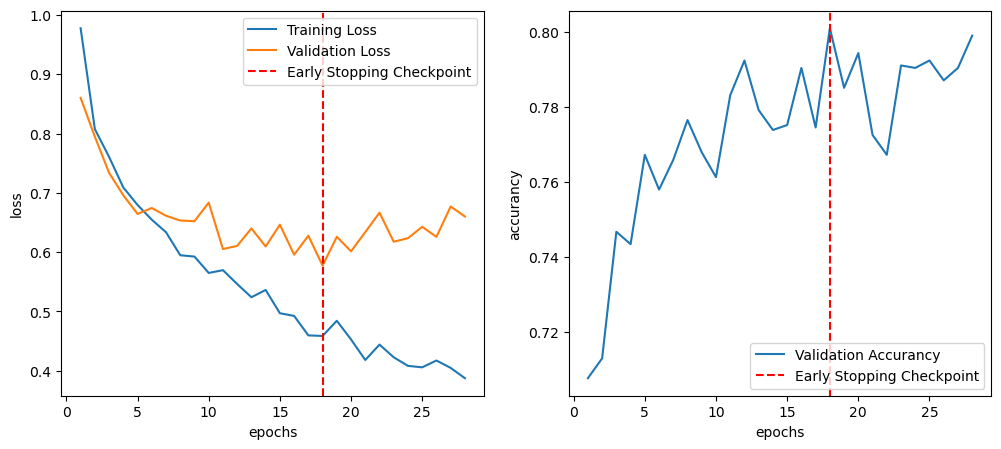

In [10]:
f, axes = plt.subplots(1,2, figsize=(12,5))
minposs = val_loss.index(min(val_loss))+1 
axes[0].plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
axes[0].plot(range(1,len(val_loss)+1),val_loss,label='Validation Loss')
axes[0].axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')
axes[0].set_xlabel('epochs')
axes[0].set_ylabel('loss')
axes[0].legend()

axes[1].plot(range(1,len(val_accurancy)+1),val_accurancy, label='Validation Accurancy')
axes[1].axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')
axes[1].set_xlabel('epochs')
axes[1].set_ylabel('accurancy')
axes[1].legend()

plt.show()

#### Confusion Mxtrix
Misunderstanding normal epithelial as cancer epithelial is the biggest weak point, it means that the feature the model capture between them is similar. The normalization transformation for datasets has already improved the model better separate the two classes. However, the result is limited, more transformation method should be used in this case.

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


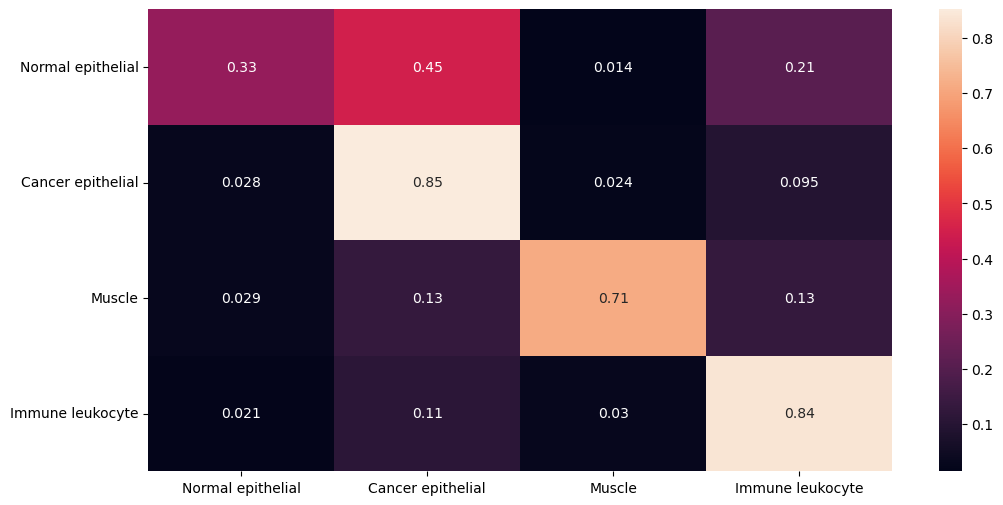

In [12]:
def plot_confusion(model, valoader):
    pred_label = []
    true_label = []

    # iterate over validation data
    for inputs, labels in validation_loader:
            output = model(inputs) # Feed Network

            output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
            pred_label.extend(output) # Save Prediction

            labels = labels.data.cpu().numpy()
            true_label.extend(labels) # Save Truth

    # classes
    classes = ('Normal epithelial', 'Cancer epithelial', 'Muscle', 'Immune leukocyte')

    # Build confusion matrix
    cf_matrix = confusion_matrix(true_label, pred_label)
    df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None],
                         index = [i for i in classes],
                         columns = [i for i in classes])

    plt.figure(figsize = (12,6))
    sn.heatmap(df_cm, annot=True)
    plt.show()

    
Conv_model.load_state_dict(torch.load('/kaggle/working/Conv_net.pth'))
plot_confusion(Conv_model, validation_loader)

#### Show Model Interpretation

In [13]:
def show_attribution(model):
    # set model and image path
    model = model.eval()
    img_path = '/kaggle/input/deep-learning-for-msc-2022-23/train/1000.png'
    
    # define transformation
    transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
    
    # load and apply transform
    img = Image.open(img_path)
    transformed_img = transform(img)
    inputs = transform(img).unsqueeze(0)
    
    # predict and get the score
    output = model(inputs)
    output = F.softmax(output, dim=1)
    prediction_score, pred_label_idx = torch.topk(output, 1)
    pred_label_idx.squeeze_()
    print('Predicted:', pred_label_idx.cpu().numpy(), '(', prediction_score.squeeze().item(), ')')
    
    # define custom color
    default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)
    # intergradient with noise tunnel
    integrated_gradients = IntegratedGradients(model)
    noise_tunnel = NoiseTunnel(integrated_gradients)
    
    # visualization
    attributions_ig_nt = noise_tunnel.attribute(inputs, nt_samples=10, nt_type='smoothgrad_sq', target=pred_label_idx)
    _ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True)
    
    # GradientSHAP 
    torch.manual_seed(0)
    np.random.seed(0)
    gradient_shap = GradientShap(model)

    # Defining baseline distribution of images
    rand_img_dist = torch.cat([inputs * 0, inputs * 1])
    attributions_gs = gradient_shap.attribute(inputs,
                                              n_samples=50,
                                              stdevs=0.0001,
                                              baselines=rand_img_dist,
                                              target=pred_label_idx)
    
    # visualization
    _ = viz.visualize_image_attr_multiple(np.transpose(attributions_gs.squeeze().cpu().detach().numpy(), (1,2,0)),
                                          np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                          ["original_image", "heat_map"],
                                          ["all", "absolute_value"],
                                          cmap=default_cmap,
                                          show_colorbar=True)
    
    # Occlusion ( sliding window 10 x 10 ) the feature is small in 100 x 100 image 
    occlusion = Occlusion(model)
    attributions_occ = occlusion.attribute(inputs,
                                           strides = (3, 5, 5),
                                           target=pred_label_idx,
                                           sliding_window_shapes=(3,10, 10),
                                           baselines=0)
    
    # visualization
    _ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )
    
    # Occlusion ( sliding window 20 x 20 ) 
    occlusion = Occlusion(model)
    attributions_occ = occlusion.attribute(inputs,
                                           strides = (3, 10, 10),
                                           target=pred_label_idx,
                                           sliding_window_shapes=(3,20, 20),
                                           baselines=0)
    
    # visualization
    _ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                          np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                          ["original_image", "heat_map"],
                                          ["all", "positive"],
                                          show_colorbar=True,
                                          outlier_perc=2,
                                         )

Predicted: 1 ( 0.9872391819953918 )


/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/comm.py:232: UserWarning: Using -1 to represent CPU tensor is deprecated. Please use a device object or string instead, e.g., "cpu".
  'Using -1 to represent CPU tensor is deprecated. Please use a '


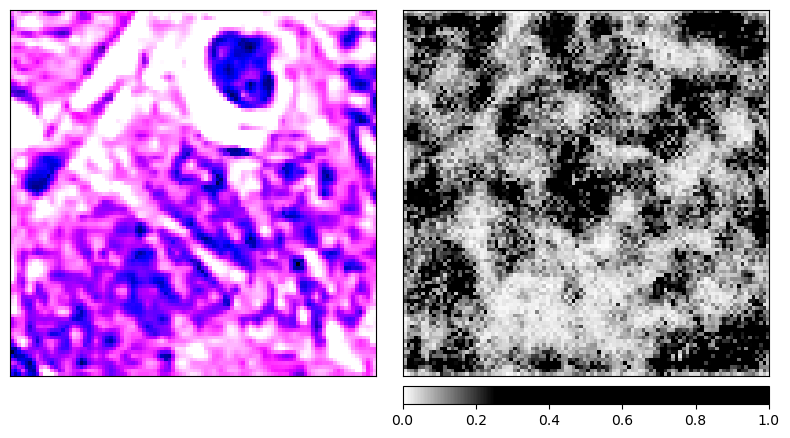

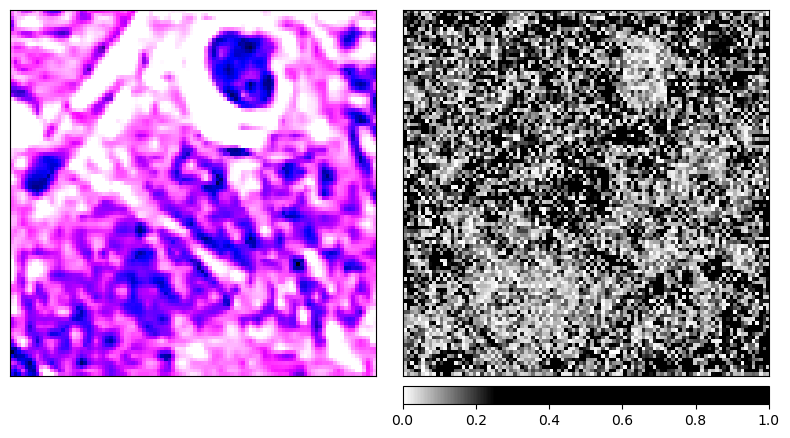

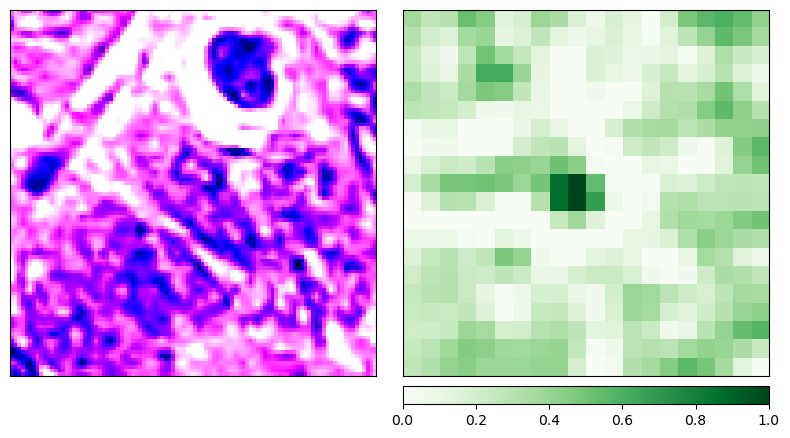

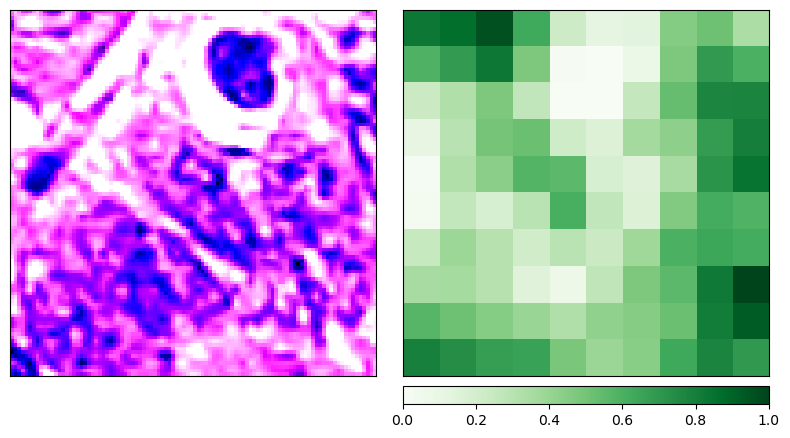

In [14]:
show_attribution(Conv_model)

#### Test Dataset

In [16]:
class TestDataset(Dataset):
    def __init__(self, path, transform=None):
        self.image_paths = glob.glob(path + '*')
        self.transform = transform

    def __getitem__(self, index):
        img = io.imread(self.image_paths[index])
        if self.transform:
            img = self.transform(img)
        return img, self.image_paths[index][-9:]

    def __len__(self):
        return len(self.image_paths)

#### Define test loop
Predict the dataset in test loader and create final result as submission.csv

In [17]:
def test_loop(model, test_loader, out_path = None):
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        
    model.eval()
    model = model.to(device)
    test_loss = 0
    correct = 0
    for i, (data,samples_fname) in enumerate(testloader, 0):
            with torch.no_grad():
                inputs = data
                inputs = inputs.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)  # get the index of the max log-probability
    if out_path:
        df = pd.DataFrame(samples_fname,  columns=['Filename'])
        df['Label'] = predicted.cpu().numpy()
        df.to_csv(out_path, index = False, header = 1)
    return predicted

#### Test
Overall Score on Kaggle: 0.92063

In [22]:
test_dataset = TestDataset(path = '/kaggle/input/deep-learning-for-msc-2022-23/test/',
                           transform = transforms.Compose([
                                           transforms.ToTensor(),
                                           transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]))
testloader = DataLoader(test_dataset, batch_size=len(test_dataset), num_workers=0)
Conv_model.load_state_dict(torch.load('/kaggle/working/Conv_net.pth'))
summary(Conv_model, (3, 100, 100))
test_loop(Conv_model, testloader, '/kaggle/working/submission.csv')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 100, 100]             448
            Conv2d-2         [-1, 16, 100, 100]             448
       BatchNorm2d-3         [-1, 16, 100, 100]              32
       BatchNorm2d-4         [-1, 16, 100, 100]              32
            Conv2d-5         [-1, 32, 100, 100]           4,640
            Conv2d-6         [-1, 32, 100, 100]           4,640
       BatchNorm2d-7         [-1, 32, 100, 100]              64
       BatchNorm2d-8         [-1, 32, 100, 100]              64
         MaxPool2d-9           [-1, 32, 50, 50]               0
        MaxPool2d-10           [-1, 32, 50, 50]               0
           Conv2d-11           [-1, 64, 50, 50]          18,496
      BatchNorm2d-12           [-1, 64, 50, 50]             128
           Conv2d-13           [-1, 64, 50, 50]          18,496
           Conv2d-14          [-1, 128,

tensor([0, 0, 1,  ..., 1, 2, 1], device='cuda:0')

#### Define a training session just for Ray tune (Resnet)
Resnet 18 is used for this case, since the memory is limited and our input size is 100 x 100, a large model is not necessary.  
Configs = learning rate, and batch size  

In [24]:
def train_resnet(config, epoch_num = 10, checkpoint_dir=None, data_dir=None):
    net = torchvision.models.resnet18(pretrained=True)
    net.conv1 = torch.nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    net.fc = torch.nn.Linear(net.fc.in_features, 4)  # number of class = 4
    
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            net = nn.DataParallel(net)
    net.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=config["lr"])

    if checkpoint_dir:
        model_state, optimizer_state = torch.load(
            os.path.join(checkpoint_dir, "checkpoint"))
        net.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)

    trainset = CellNucleiDataset(csv_file='/kaggle/input/deep-learning-for-msc-2022-23/train.csv',
                                 root_dir='/kaggle/input/deep-learning-for-msc-2022-23/train/',
                                 transform = transforms.Compose([
                                             transforms.ToTensor(),
                                             transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]))

    test_abs = int(len(trainset) * 0.8)
    train_subset, val_subset = random_split(
        trainset, [test_abs, len(trainset) - test_abs])

    trainloader = DataLoader(
        train_subset,
        batch_size=int(config["batch_size"]),
        shuffle=True,
        num_workers=0)
    valloader = DataLoader(
        val_subset,
        batch_size=int(config["batch_size"]),
        shuffle=True,
        num_workers=0)

    for epoch in range(epoch_num):  # loop over the dataset multiple times
        running_loss = 0.0
        epoch_steps = 0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            epoch_steps += 1
            if i % 2000 == 1999:  # print every 2000 mini-batches
                print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1,
                                                running_loss / epoch_steps))
                running_loss = 0.0

        # Validation loss
        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        for i, data in enumerate(valloader, 0):
            with torch.no_grad():
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = net(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                loss = criterion(outputs, labels)
                val_loss += loss.cpu().numpy()
                val_steps += 1

        with tune.checkpoint_dir(epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, "checkpoint")
            torch.save((net.state_dict(), optimizer.state_dict()), path)

        tune.report(loss=(val_loss / val_steps), accuracy=correct / total)
    print("Finished Training")

#### Define main function for ray tune (Resnet)
Because of the hardware limitation, run for only three samples with a maximum of 10 epochs and use one GPU T4 for each trial.  
Configs set as below:

* learning rate: 10e-4 ~ 10e-1  
* batch size: 2, 4, 8


I am sorry that I could not run two Ray tune processes in one session at the same time in Kaggle. And actually, GPU T4 is good for model 1(Conv net above) however GPU P100 is better for Resnet since it has more memory allocated. So there is no ouput for this part but the final oupput config is provided below. : (  

config = {'lr': 0.0001429375294877433, 'batch_size': 8}

In [26]:
def main(num_samples=10, max_num_epochs=10, gpus_per_trial=1):

    config = {
        "lr": tune.loguniform(1e-4, 1e-1),
        "batch_size": tune.choice([2, 4, 8])
    }
    
    scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=max_num_epochs,
        grace_period=1,
        reduction_factor=2)
    reporter = CLIReporter(
        parameter_columns=["lr", "batch_size"],
        metric_columns=["loss", "accuracy", "training_iteration"])
    result = tune.run(
        partial(train_resnet, data_dir='/kaggle/input/deep-learning-for-msc-2022-23/train'),
        resources_per_trial={"cpu": 1, "gpu": gpus_per_trial},
        config=config,
        num_samples=num_samples,
        scheduler=scheduler,
        progress_reporter=reporter)

    best_trial = result.get_best_trial("loss", "min", "last")
    print("Best trial config: {}".format(best_trial.config))
    print("Best trial final validation loss: {}".format(
        best_trial.last_result["loss"]))
    print("Best trial final validation accuracy: {}".format(
        best_trial.last_result["accuracy"]))

#     best_trained_model = ConvNet(best_trial.config["l1"], best_trial.config["l2"])
#     device = "cpu"
#     if torch.cuda.is_available():
#         device = "cuda:0"
#         if gpus_per_trial > 1:
#             best_trained_model = nn.DataParallel(best_trained_model)
#     best_trained_model.to(device)

#     best_checkpoint_dir = best_trial.checkpoint.dir_or_data
#     model_state, optimizer_state = torch.load(os.path.join(best_checkpoint_dir, "checkpoint"))
#     best_trained_model.load_state_dict(model_state)
    
# if __name__ == "__main__":
    # You can change the number of GPUs per trial here:
#     main(num_samples=3, max_num_epochs=10, gpus_per_trial=1)

#### Define train function for keep on training the model woth best config we get from Ray tune (Resnet)
Record training loss and validation accuracy and loss in every epoch, and return them in the end for acc/loss plot.  
Record the best accuracy and compare it in every epoch (model as well), and set a patient for early stopping.

In [27]:
def train_Resnet_model(config, epoch_num = 10, checkpoint_dir=None, data_dir=None):  
#     net = ConvNet(config["l1"], config["l2"])
    net = torchvision.models.resnet18(pretrained=True)
    net.conv1 = torch.nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    net.fc = torch.nn.Linear(net.fc.in_features, 4) 

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            net = nn.DataParallel(net)
    net.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=config["lr"])

    trainset = CellNucleiDataset(csv_file='/kaggle/input/deep-learning-for-msc-2022-23/train.csv',
                                 root_dir='/kaggle/input/deep-learning-for-msc-2022-23/train/',
                                 transform = ToTensor())

    test_abs = int(len(trainset) * 0.8)
    train_subset, val_subset = random_split(
        trainset, [test_abs, len(trainset) - test_abs])

    trainloader = DataLoader(
        train_subset,
        batch_size=int(config["batch_size"]),
        shuffle=True,
        num_workers=8)
    valloader = DataLoader(
        val_subset,
        batch_size=int(config["batch_size"]),
        shuffle=True,
        num_workers=8)
    
    avg_train_losses = []
    avg_val_losses = []
    best_accurancy = 0
#     train_accurancy = []
    val_accurancy = []
    
    for epoch in range(epoch_num):  # loop over the dataset multiple times
        running_loss = 0.0
        epoch_steps = 0
        correct = 0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            epoch_steps += 1
            if i % 2000 == 1999:  # print every 2000 mini-batches
                print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1,running_loss / epoch_steps))
                running_loss = 0.0
        avg_train_losses.append(running_loss / epoch_steps)

        
        # Validation loss
        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        for i, data in enumerate(valloader, 0):
            with torch.no_grad():
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = net(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                loss = criterion(outputs, labels)
                val_loss += loss.cpu().numpy()
                val_steps += 1

        avg_val_losses.append(val_loss / val_steps)
        val_accurancy.append(correct / total)
        print('Epoch {}:'.format(epoch), 'Validation loss: {:.6f}'.format(val_loss / val_steps), 'Validation accuracy: {:.6f}'.format(correct / total))
        
        # Early Stopping
        path = '/kaggle/working/Resnet_net.pth'
        patience = 5
        
        if val_accurancy[epoch] > best_accurancy:
            best_accurancy = val_accurancy[epoch]
            es = 0
            torch.save(net.state_dict(), path)
        else:
            es += 1
            print("Early stopping counter {} of {}".format(es, patience), 'Best accurancy: {:.6f}'.format(best_accurancy), 'Validation accurancy: {:.6f}'.format(val_accurancy[epoch]))
            if es >= patience:
                print("Early stopping with best_acc: {:.6f}".format(best_accurancy), "and val_acc for this epoch: {:.6f}".format(val_accurancy[epoch]))
                break

    print("Finished Training")
    return net, avg_train_losses, avg_val_losses, val_accurancy, valloader

In [28]:
config = {'lr': 0.0001429375294877433, 'batch_size': 8}
Resnet_model, train_loss, val_loss, val_accurancy, validation_loader = train_Resnet_model(config, epoch_num = 50, checkpoint_dir=None, data_dir=None)

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessiv

Epoch 0: Validation loss: 0.474864 Validation accuracy: 0.845238


E0327 10:17:37.513614017    1096 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0327 10:17:37.574523820    1096 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0327 10:17:37.636790326    1096 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0327 10:17:37.701396687    1096 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0327 10:17:37.765911532    1096 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0327 10:17:37.831013846    1096 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0327 10:17:37.887368146    1096 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0327 10:17:37.963084561    1096 fork_posix.cc:76]           Other th

Epoch 1: Validation loss: 0.328771 Validation accuracy: 0.894841


E0327 10:18:29.559449042    1096 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0327 10:18:29.616042654    1096 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0327 10:18:29.678421039    1096 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0327 10:18:29.738514711    1096 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0327 10:18:29.801004912    1096 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0327 10:18:29.864358785    1096 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0327 10:18:29.924278665    1096 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0327 10:18:29.984929857    1096 fork_posix.cc:76]           Other th

Epoch 2: Validation loss: 0.248183 Validation accuracy: 0.916005


E0327 10:19:18.548243291    1096 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0327 10:19:18.604135290    1096 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0327 10:19:18.665337483    1096 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0327 10:19:18.723451757    1096 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0327 10:19:18.782454760    1096 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0327 10:19:18.843480632    1096 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0327 10:19:18.902137342    1096 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0327 10:19:18.964921687    1096 fork_posix.cc:76]           Other th

Epoch 3: Validation loss: 0.187827 Validation accuracy: 0.939153


E0327 10:20:08.983731547    1096 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0327 10:20:09.042466347    1096 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0327 10:20:09.159059880    1096 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0327 10:20:09.219146565    1096 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0327 10:20:09.281086179    1096 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0327 10:20:09.345240249    1096 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0327 10:20:09.404818278    1096 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0327 10:20:51.152346158    1096 fork_posix.cc:76]           Other th

Epoch 4: Validation loss: 0.163196 Validation accuracy: 0.951058


E0327 10:20:58.259722205    1096 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0327 10:20:58.317922033    1096 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0327 10:20:58.382564506    1096 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0327 10:20:58.496850150    1096 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0327 10:20:58.559036268    1096 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0327 10:20:58.620971711    1096 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0327 10:20:58.681762256    1096 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0327 10:21:40.554975297    1096 fork_posix.cc:76]           Other th

Epoch 5: Validation loss: 0.307080 Validation accuracy: 0.916005
Early stopping counter 1 of 5 Best accurancy: 0.951058 Validation accurancy: 0.916005


E0327 10:21:47.933617885    1096 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0327 10:21:47.990653536    1096 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0327 10:21:48.051915114    1096 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0327 10:21:48.113629320    1096 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0327 10:21:48.174998291    1096 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0327 10:21:48.239028144    1096 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0327 10:21:48.300676216    1096 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0327 10:21:48.367271521    1096 fork_posix.cc:76]           Other th

Epoch 6: Validation loss: 0.190356 Validation accuracy: 0.939815
Early stopping counter 2 of 5 Best accurancy: 0.951058 Validation accurancy: 0.939815


E0327 10:22:37.049468616    1096 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0327 10:22:37.103741860    1096 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0327 10:22:37.162734656    1096 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0327 10:22:37.225605648    1096 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0327 10:22:37.287239067    1096 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0327 10:22:37.348973886    1096 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0327 10:22:37.407937389    1096 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0327 10:22:37.468837637    1096 fork_posix.cc:76]           Other th

Epoch 7: Validation loss: 0.197360 Validation accuracy: 0.937169
Early stopping counter 3 of 5 Best accurancy: 0.951058 Validation accurancy: 0.937169


E0327 10:23:25.681398621    1096 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0327 10:23:25.745743870    1096 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0327 10:23:25.812628736    1096 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0327 10:23:25.883392029    1096 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0327 10:23:25.951662528    1096 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0327 10:23:26.011811936    1096 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0327 10:23:26.075961496    1096 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0327 10:23:26.140291314    1096 fork_posix.cc:76]           Other th

Epoch 8: Validation loss: 0.196616 Validation accuracy: 0.935185
Early stopping counter 4 of 5 Best accurancy: 0.951058 Validation accurancy: 0.935185


E0327 10:24:14.583328391    1096 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0327 10:24:14.638308207    1096 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0327 10:24:14.698753072    1096 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0327 10:24:14.760680252    1096 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0327 10:24:14.825881486    1096 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0327 10:24:14.892064015    1096 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0327 10:24:14.954757696    1096 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0327 10:24:15.012972504    1096 fork_posix.cc:76]           Other th

Epoch 9: Validation loss: 0.238241 Validation accuracy: 0.931878
Early stopping counter 5 of 5 Best accurancy: 0.951058 Validation accurancy: 0.931878
Early stopping with best_acc: 0.951058 and val_acc for this epoch: 0.931878
Finished Training


#### Plot accurancy, losses and early stopping check point
The same situation is happening in the Resnet model too, but the overall performance is better. We can see that the limitation of the validation accuracy is around 0.93, but the training loss is still decreasing. And the conclusion is the same as well, I think it is because our dataset is limited, there is not lots of similarity between the training and validation set. The use of cross-validation or more methods in transforming samples (like Crop or Cut off) should solve this issue and get a higher validation accuracy.

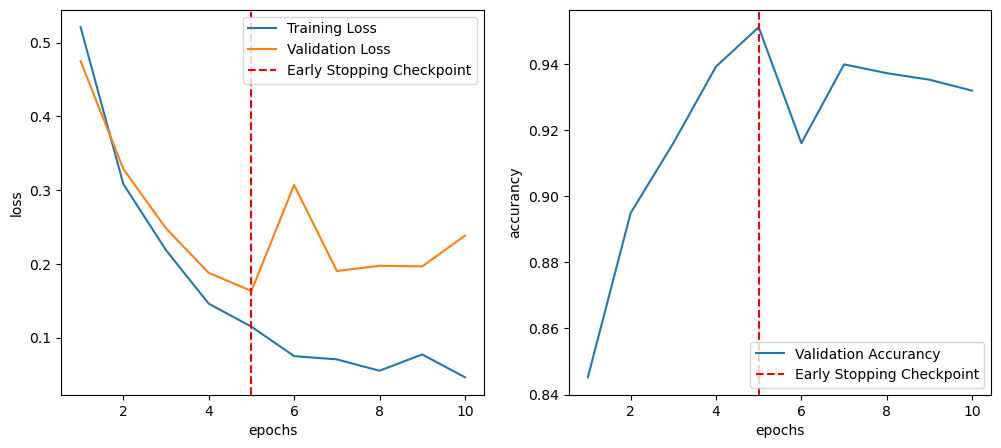

In [29]:
f, axes = plt.subplots(1,2, figsize=(12,5))
minposs = val_loss.index(min(val_loss))+1 
axes[0].plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
axes[0].plot(range(1,len(val_loss)+1),val_loss,label='Validation Loss')
axes[0].axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

axes[0].set_xlabel('epochs')
axes[0].set_ylabel('loss')
axes[0].legend()

axes[1].plot(range(1,len(val_accurancy)+1),val_accurancy, label='Validation Accurancy')
axes[1].axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')
axes[1].set_xlabel('epochs')
axes[1].set_ylabel('accurancy')
axes[1].legend()

plt.show()

#### Confusion Mxtrix
Misunderstanding normal epithelial as cancer epithelial is still the weak point, but the situation is way better this time. More transformation method should be used in this case.

E0327 10:25:57.113053911    1096 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0327 10:25:57.169831032    1096 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0327 10:25:57.229305978    1096 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0327 10:25:57.292966811    1096 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0327 10:25:57.348582606    1096 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0327 10:25:57.410405724    1096 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0327 10:25:57.471450737    1096 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0327 10:25:57.534867760    1096 fork_posix.cc:76]           Other th

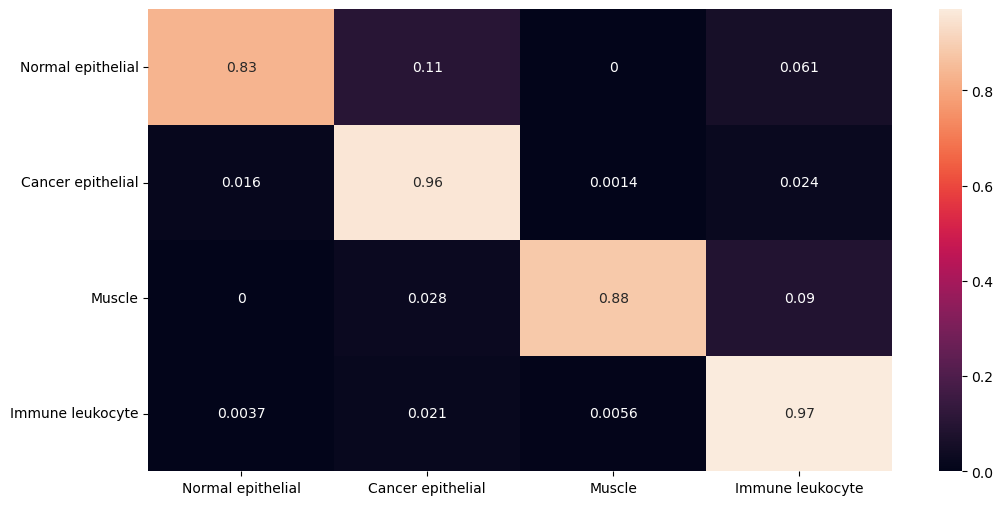

In [30]:
Resnet_model.load_state_dict(torch.load('/kaggle/working/Resnet_net.pth'))
plot_confusion(Resnet_model, validation_loader)

#### Show Model Interpretation

Predicted: 0 ( 0.9580704569816589 )


/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/comm.py:232: UserWarning: Using -1 to represent CPU tensor is deprecated. Please use a device object or string instead, e.g., "cpu".
  'Using -1 to represent CPU tensor is deprecated. Please use a '


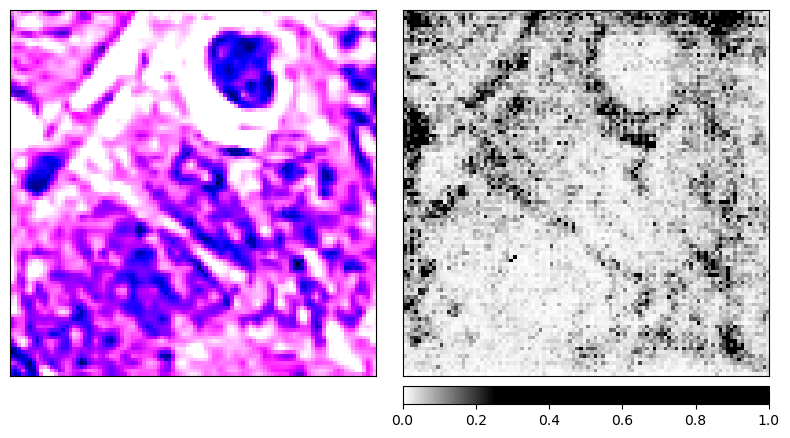

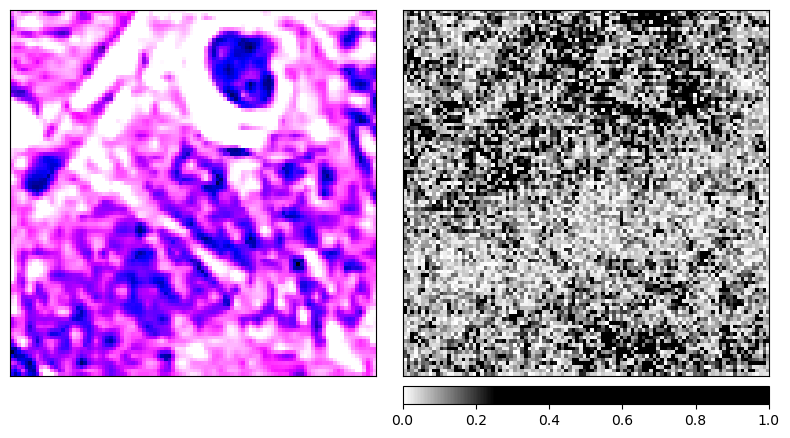

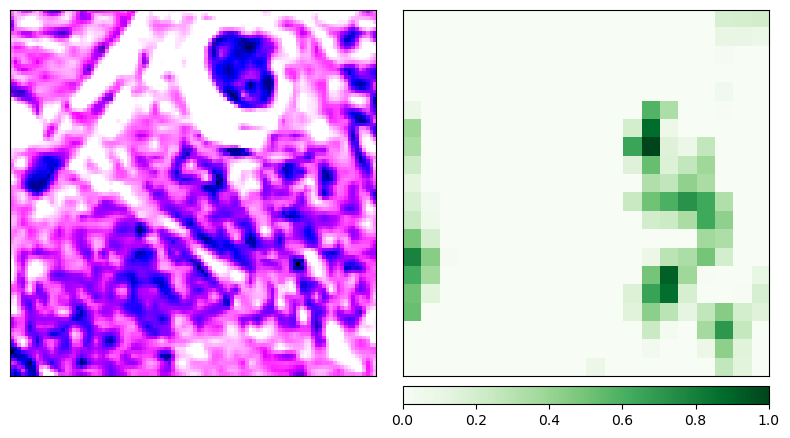

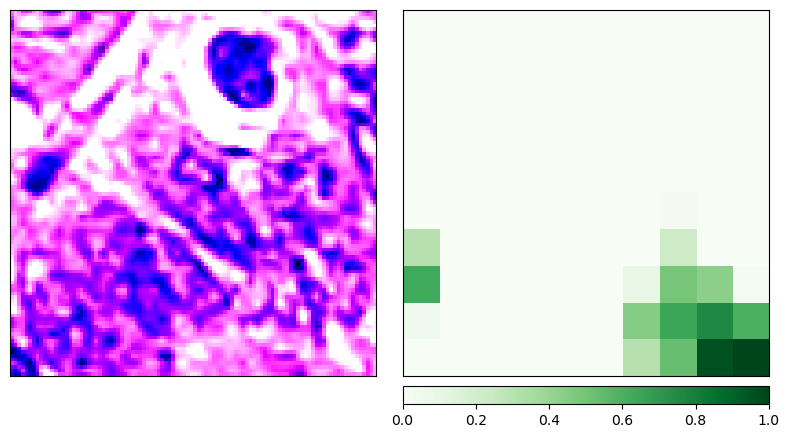

In [31]:
show_attribution(Resnet_model)

#### Test
Overall Score on Kaggle: 0.97738

In [32]:
test_dataset = TestDataset(path = '/kaggle/input/deep-learning-for-msc-2022-23/test/', transform = ToTensor())
testloader = DataLoader(test_dataset, batch_size=len(test_dataset), num_workers=0)
# model = ConvNet(64, 256)
Resnet_model.load_state_dict(torch.load('/kaggle/working/Resnet_net.pth'))
test_loop(Resnet_model, testloader, '/kaggle/working/submission_resnet.csv')

tensor([0, 0, 1,  ..., 0, 2, 0], device='cuda:0')